<a href="https://colab.research.google.com/github/micheusch/sagemaker/blob/main/binary_classifier_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

In [192]:
import os

OUTPUT_DIR = './outdir'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
!pip install -U xlrd
df = pd.read_excel(open('default of credit card clients.xls' ,'rb'), header =1, index_col=0)

In [62]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

## EDA

In [118]:
# Analysis of class imbalance
y.value_counts()/len(y)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

## Building a minimal baseline

In [123]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.predict(X_valid)
dummy_clf.score(X_valid, y_valid)

0.78

## Build a NN model

### First, we need to configure the network to be able to overfit our training data

In [171]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
EPOCHS = 20
HIDDEN_STATES = 100
FEATURES = X.shape[1]
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.000

In [172]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.values))
valid_data = TrainData(torch.FloatTensor(X_valid), 
                       torch.FloatTensor(y_valid.values))

In [173]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [179]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(FEATURES, HIDDEN_STATES) 
        self.layer_2 = nn.Linear(HIDDEN_STATES, HIDDEN_STATES)
        self.layer_out = nn.Linear(HIDDEN_STATES, 1) 
        self.sig = nn.Sigmoid()
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT)
        self.batchnorm1 = nn.BatchNorm1d(HIDDEN_STATES)
        self.batchnorm2 = nn.BatchNorm1d(HIDDEN_STATES)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        # x = self.sig(x)
        return x

In [180]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    model.train()
    losses = AverageMeter()

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_size = y_batch.size(0)

        optimizer.zero_grad()       
        y_pred = model(X_batch)        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        losses.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()

    return losses.avg
  
def valid_fn(valid_loader, model, criterion, optimizer, epoch, device):
    model.eval()
    losses = AverageMeter()
    preds = []

    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_size = y_batch.size(0)
        
        with torch.no_grad():
          y_pred = model(X_batch)        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        losses.update(loss.item(), batch_size)

        preds.append(y_pred.sigmoid().to('cpu').numpy())
      
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [181]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

from sklearn.metrics import accuracy_score

In [193]:
train_loss = []
valid_loss = []
best_score = 0.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for e in range(1, EPOCHS+1):

    avg_train_loss = \
      train_fn(train_loader, model, criterion, optimizer, e, device)
    avg_valid_loss, predictions = \
      valid_fn(valid_loader, model, criterion, optimizer, e, device)
    
    train_loss.append(avg_train_loss)
    valid_loss.append(avg_valid_loss)

    acc = accuracy_score(np.round(predictions[:,0]), y_valid.values)
    if best_score < acc:
      best_score = acc
      torch.save({'model': model.state_dict(),
                  'predictions': predictions},
                  OUTPUT_DIR + f"model_best.pth")      
    print(f'Epoch {e+0:03}: | Loss: {avg_train_loss:.5f} | ' +
          f'Val Loss: {avg_valid_loss:.5f} | Acc: {acc:.5f}')   

print(f'BestAcc {best_score:.3f}')


Epoch 001: | Loss: 0.49807 | Val Loss: 0.45245 | Acc: 0.70778
Epoch 002: | Loss: 0.43909 | Val Loss: 0.45076 | Acc: 0.70111
Epoch 003: | Loss: 0.43354 | Val Loss: 0.44587 | Acc: 0.70838
Epoch 004: | Loss: 0.43041 | Val Loss: 0.44259 | Acc: 0.70485
Epoch 005: | Loss: 0.42714 | Val Loss: 0.44048 | Acc: 0.72495
Epoch 006: | Loss: 0.42584 | Val Loss: 0.44246 | Acc: 0.70131
Epoch 007: | Loss: 0.42410 | Val Loss: 0.43663 | Acc: 0.71212
Epoch 008: | Loss: 0.42240 | Val Loss: 0.43609 | Acc: 0.71990
Epoch 009: | Loss: 0.42109 | Val Loss: 0.43536 | Acc: 0.70616
Epoch 010: | Loss: 0.42042 | Val Loss: 0.43593 | Acc: 0.71606
Epoch 011: | Loss: 0.41924 | Val Loss: 0.43261 | Acc: 0.71859
Epoch 012: | Loss: 0.41701 | Val Loss: 0.43622 | Acc: 0.71616
Epoch 013: | Loss: 0.41577 | Val Loss: 0.43841 | Acc: 0.71051
Epoch 014: | Loss: 0.41258 | Val Loss: 0.43702 | Acc: 0.71556
Epoch 015: | Loss: 0.41190 | Val Loss: 0.44126 | Acc: 0.71687
Epoch 016: | Loss: 0.41134 | Val Loss: 0.44813 | Acc: 0.71869
Epoch 01

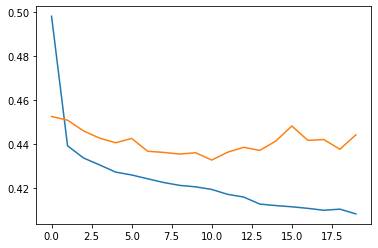

In [194]:
plt.plot(range(EPOCHS),train_loss)
plt.plot(range(EPOCHS),valid_loss);